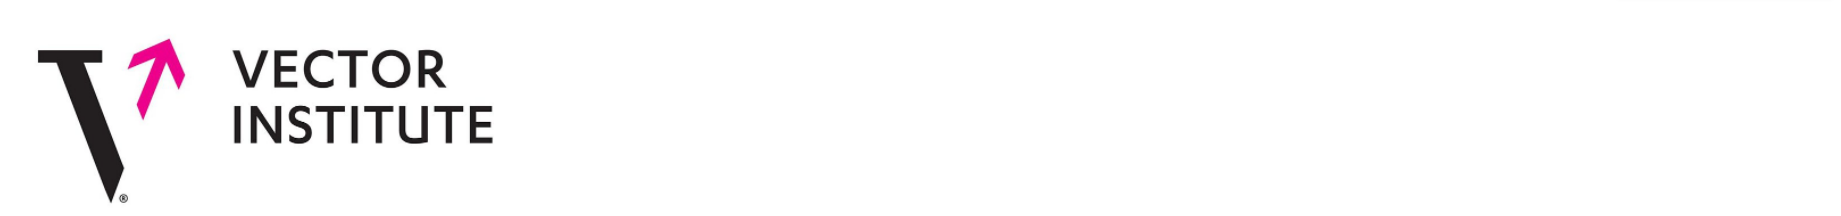

### **Welcome to the Bias in AI Program!**
This program is offered by Vector Institute.

Instructor: Sayyed Nezhadi | Assignment Developer: Rishav Raj Agarwal |Course Tutors: Anastasia Razdaibiedina and Rishav Raj Agarwal | Course Director: Shingai Manjengwa (@Tjido) 

### ***Never stop learning!***

### **Assignment 2**: Training a simple image classification model.

**Aim:** To train a binary gender classification model. You will understand how image classification models are trained and you will be able to make realtime predicitions. 

Much of the code here is adopted from this [git repo](https://github.com/oarriaga/face_classification).

This assignment is inspired by the [FairFace ECCV Workshop](http://chalearnlap.cvc.uab.es/challenge/38/description/). You can refer to their submissions and videos for some insights. 



In [ ]:
# check whether GPU is provided
!nvcc --version
# if no GPU then make sure to turn Runtime to GPU and try again


### Installing libraries



In [ ]:
#Note: You may have to restart the runtime after this step. 
#This needs to be done only once. 

!pip install keras==2.0.5
!pip install 'h5py==2.10.0' --force-reinstall

%tensorflow_version 1.1

### Defining the model

In [ ]:
#We use the Mini Exception Model.Please refer to the assignemnt pdf for more details.

from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2

def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)
    model = Model(img_input, output)
    return model

### Data management and data augumentation functions 

In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from random import shuffle
import os
import cv2


class DataManager(object):
    """
    Class for loading dataset.
    """
    def __init__(self, dataset_name='ijbc',
                 dataset_path=None, image_size=(48, 48)):
        self.dataset_name = dataset_name
        self.dataset_path = dataset_path
        self.image_size = image_size
      
    def get_data(self, meta_path = None):
        if self.dataset_name == 'ijbc':
            ground_truth_data = self._load_ijbc(meta_path)
        return ground_truth_data

    ###########################################################################
    # You can add your customm data loaders here ##############################
    ###########################################################################

    def _load_ijbc(self, meta_path = None):
        lables = np.genfromtxt(meta_path,delimiter=",", skip_header=1)
        image_names = [str(int(i)) +".jpg" for i in lables[:, 0]]
        gender_classes = lables[:, 4]
        return dict(zip(image_names, gender_classes))

def get_labels(dataset_name):
    if dataset_name == 'ijbc':
        return {0: 'm', 1: 'f'}
    else:
        raise Exception('Invalid dataset name')


def get_class_to_arg(dataset_name='ijbc'):
    if dataset_name == 'ijbc':
        return {'m': 0, 'f': 1}
    else:
        raise Exception('Invalid dataset name')

def split_data(ground_truth_data, validation_split=.2, do_shuffle=False):
    ground_truth_keys = sorted(ground_truth_data.keys())
    if do_shuffle is not False:
        shuffle(ground_truth_keys)
    training_split = 1 - validation_split
    num_train = int(training_split * len(ground_truth_keys))
    train_keys = ground_truth_keys[:num_train]
    validation_keys = ground_truth_keys[num_train:]
    return train_keys, validation_keys




In [ ]:
import numpy as np
from random import shuffle
import scipy.ndimage as ndi
from cv2 import imread, resize
import cv2
import os

def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

def to_categorical(integer_classes, num_classes=2):
    integer_classes = np.asarray(integer_classes, dtype='int')
    num_samples = integer_classes.shape[0]
    categorical = np.zeros((num_samples, num_classes))
    categorical[np.arange(num_samples), integer_classes] = 1
    return categorical

class ImageGenerator(object):
    """ Image generator with saturation, brightness, lighting, contrast,
    horizontal flip and vertical flip transformations. It supports
    bounding boxes coordinates.
    """
    def __init__(self, ground_truth_data, batch_size, image_size,
                 train_keys, validation_keys,
                 path_prefix=None,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 horizontal_flip_probability=0.5,
                 vertical_flip_probability=0.5,
                 do_random_crop=False,
                 grayscale=False,
                 zoom_range=[0.75, 1.25],
                 translation_factor=.3):

        self.ground_truth_data = ground_truth_data
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.validation_keys = validation_keys
        self.image_size = image_size
        self.grayscale = grayscale
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.horizontal_flip_probability = horizontal_flip_probability
        self.vertical_flip_probability = vertical_flip_probability
        self.do_random_crop = do_random_crop
        self.zoom_range = zoom_range
        self.translation_factor = translation_factor

    def _do_random_crop(self, image_array):
        """IMPORTANT: random crop only works for classification since the
        current implementation does no transform bounding boxes"""
        height = image_array.shape[0]
        width = image_array.shape[1]
        x_offset = np.random.uniform(0, self.translation_factor * width)
        y_offset = np.random.uniform(0, self.translation_factor * height)
        offset = np.array([x_offset, y_offset])
        scale_factor = np.random.uniform(self.zoom_range[0],
                                         self.zoom_range[1])
        crop_matrix = np.array([[scale_factor, 0],
                                [0, scale_factor]])

        image_array = np.rollaxis(image_array, axis=-1, start=0)
        image_channel = [ndi.interpolation.affine_transform(image_channel,
                         crop_matrix, offset=offset, order=0, mode='nearest',
                         cval=0.0) for image_channel in image_array]

        image_array = np.stack(image_channel, axis=0)
        image_array = np.rollaxis(image_array, 0, 3)
        return image_array
    ###########################################################################
    # You can add your customm data augs here   ###############################
    ###########################################################################

    def do_random_rotation(self, image_array):
        height = image_array.shape[0]
        width = image_array.shape[1]
        x_offset = np.random.uniform(0, self.translation_factor * width)
        y_offset = np.random.uniform(0, self.translation_factor * height)
        offset = np.array([x_offset, y_offset])
        scale_factor = np.random.uniform(self.zoom_range[0],
                                         self.zoom_range[1])
        crop_matrix = np.array([[scale_factor, 0],
                                [0, scale_factor]])

        image_array = np.rollaxis(image_array, axis=-1, start=0)
        image_channel = [ndi.interpolation.affine_transform(image_channel,
                         crop_matrix, offset=offset, order=0, mode='nearest',
                         cval=0.0) for image_channel in image_array]

        image_array = np.stack(image_channel, axis=0)
        image_array = np.rollaxis(image_array, 0, 3)
        return image_array

    def _gray_scale(self, image_array):
        return image_array.dot([0.299, 0.587, 0.114])

    def saturation(self, image_array):
        gray_scale = self._gray_scale(image_array)
        alpha = 2.0 * np.random.random() * self.brightness_var
        alpha = alpha + 1 - self.saturation_var
        image_array = (alpha * image_array + (1 - alpha) *
                       gray_scale[:, :, None])
        return np.clip(image_array, 0, 255)

    def brightness(self, image_array):
        alpha = 2 * np.random.random() * self.brightness_var
        alpha = alpha + 1 - self.saturation_var
        image_array = alpha * image_array
        return np.clip(image_array, 0, 255)

    def contrast(self, image_array):
        gray_scale = (self._gray_scale(image_array).mean() *
                      np.ones_like(image_array))
        alpha = 2 * np.random.random() * self.contrast_var
        alpha = alpha + 1 - self.contrast_var
        image_array = image_array * alpha + (1 - alpha) * gray_scale
        return np.clip(image_array, 0, 255)

    def lighting(self, image_array):
        covariance_matrix = np.cov(image_array.reshape(-1, 3) /
                                   255.0, rowvar=False)
        eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigen_vectors.dot(eigen_values * noise) * 255
        image_array = image_array + noise
        return np.clip(image_array, 0, 255)

    def horizontal_flip(self, image_array, box_corners=None):
        if np.random.random() < self.horizontal_flip_probability:
            image_array = image_array[:, ::-1]
            if box_corners is not None:
                box_corners[:, [0, 2]] = 1 - box_corners[:, [2, 0]]
        return image_array, box_corners

    def vertical_flip(self, image_array, box_corners=None):
        if (np.random.random() < self.vertical_flip_probability):
            image_array = image_array[::-1]
            if box_corners is not None:
                box_corners[:, [1, 3]] = 1 - box_corners[:, [3, 1]]
        return image_array, box_corners

    def transform(self, image_array, box_corners=None):
        shuffle(self.color_jitter)
        for jitter in self.color_jitter:
            image_array = jitter(image_array)

        if self.lighting_std:
            image_array = self.lighting(image_array)

        if self.horizontal_flip_probability > 0:
            image_array, box_corners = self.horizontal_flip(image_array,
                                                            box_corners)

        if self.vertical_flip_probability > 0:
            image_array, box_corners = self.vertical_flip(image_array,
                                                          box_corners)
        return image_array, box_corners

    def preprocess_images(self, image_array):
        return preprocess_input(image_array)

    def flow(self, mode='train'):
            while True:
                if mode == 'train':
                    shuffle(self.train_keys)
                    keys = self.train_keys
                elif mode == 'val' or mode == 'demo':
                    shuffle(self.validation_keys)
                    keys = self.validation_keys
                else:
                    raise Exception('invalid mode: %s' % mode)

                inputs = []
                targets = []
                for key in keys:
                    image_path = os.path.join(self.path_prefix, key)
                    if not os.path.exists(image_path):
                      continue
                    image_array = imread(image_path)
                    image_array = resize(image_array, self.image_size)

                    num_image_channels = len(image_array.shape)
                    if num_image_channels != 3:
                        continue

                    ground_truth = self.ground_truth_data[key]

                    if self.do_random_crop:
                        image_array = self._do_random_crop(image_array)

                    image_array = image_array.astype('float32')
                    if mode == 'train' or mode == 'demo':
                            image_array = self.transform(image_array)[0]

                    if self.grayscale:
                        image_array = cv2.cvtColor(
                                image_array.astype('uint8'),
                                cv2.COLOR_RGB2GRAY).astype('float32')
                        image_array = np.expand_dims(image_array, -1)

                    inputs.append(image_array)
                    targets.append(ground_truth)
                    if len(targets) == self.batch_size:
                        inputs = np.asarray(inputs)
                        targets = np.asarray(targets)
                        # this will not work for boxes
                        targets = to_categorical(targets)
                        if mode == 'train' or mode == 'val':
                            inputs = self.preprocess_images(inputs)
                            yield self._wrap_in_dictionary(inputs, targets)
                        inputs = []
                        targets = []

    def _wrap_in_dictionary(self, image_array, targets):
        return [image_array, targets]

### Testing function that evaluates trained models

In [ ]:
from keras.models import load_model
from sklearn.metrics import roc_auc_score, accuracy_score

def testing(model_path, val_data):
  '''
  returns the predictions and ground truths 
  '''
  prediction = []
  gt = []
  gender_classifier = load_model(gender_model_path, compile=False)

  for img_pth in val_data:
    if os.path.exists(images_path):
      img = imread(os.path.join(images_path, img_pth))
      if grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = np.expand_dims(resize(img, (h,w)), axis = 2)
      img = np.expand_dims(img, axis = 0)
      prediction.append(gender_classifier.predict(img))
      gt.append(val_data[img_pth])


  prediction = np.stack(prediction).squeeze(axis=1)
                                            
  #Getting Accuracy and ROC Score                                          
  roc_score = roc_auc_score(gt, prediction[:, 1])
  print("Roc Score is %.2f" % roc_score)
  prds = (prediction[:, 1]> .5).astype(int) 
  acc_score = accuracy_score(gt,  prds)
  print("Accuracy Score is %.2f" % acc_score)
  return prediction, gt

### Visualization function

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def viz(_data, images_path = None, mode = None, prediction = None, thresh = .5, num_imgs = 4):
  '''
  Takes in a data loader.get_data() object, a visualization mode,
  number of rows and columns for the plot and plots the images with labels
  '''
  fig = plt.figure(figsize=(min(num_imgs*3,12),num_imgs))

  
  gt = []
  prds_subset = []
  viz_subset = []

  cols = 2
  rows = num_imgs//cols
  idx = 0
  ii = 0

  keys = list(_data.keys())
  
  while idx < cols*rows:
    k = os.path.join(images_path, keys[ii])
    if os.path.exists(k):
      viz_subset.append(k)
      gt.append(_data[keys[ii]])
      idx += 1  
      if mode == "val":
        prds_subset.append(prediction[ii, 1])
    ii+=1
  grid = gridspec.GridSpec(nrows=rows, ncols=cols, figure=fig)
  for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = plt.imread(viz_subset[i])
    if mode == "val":
      if prds_subset[i] > thresh:
        pr = "Female"
      else:
        pr = "Male"
    if gt[i] == 0:
      org = "Male"
    else:
      org = "Female"
    if mode == "val":  
      plt.title("Predicted "+ pr +  ", ground truth was " + org)
    else:
       plt.title("Ground truth is " + org)
    plt.axis(False)
    plt.imshow(image)

### Download and unzip data

In [ ]:
%mkdir datasets
%cd datasets/

from IPython.display import clear_output
import zipfile
from pathlib import Path
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=10ifeK6g7Yb7-Nk0OGkPHooA0rgI9JMy0' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=10ifeK6g7Yb7-Nk0OGkPHooA0rgI9JMy0" -O ijbc.zip && rm -rf /tmp/cookies.txt
# Note that if you already have the data downloaded, this cell may ask you to replace the files or quit the process
!unzip -qq ijbc.zip
!rm -f ijbc.zip
%cd ..
%mkdir gender_models

### Setting hyperparameters

In [ ]:
#parameters

batch_size = 32 # Number of images to pach per iteration
num_epochs = 1 # it takes about 15 mins per epoch 
do_random_crop = False # Crop data augumetations turned off for now
patience = 10 #Used for early stopping in Keras
num_classes = 2 # as we have only two classes
dataset_name = 'ijbc'
input_shape = (64, 64, 1) # we resize each image to 64x64 and grasyscale them
if input_shape[2] == 1:
    grayscale = True

validation_split = 0.2 #validation size used during training

images_path = 'datasets/ijbc/images'
meta_train_path = 'datasets/ijbc/train_set.csv'
meta_test_path = 'datasets/ijbc/val_set.csv'

log_file_path = 'gender_models/gender_training.log'
trained_models_path = 'gender_models/gender_mini_XCEPTION'


### Loading data

In [ ]:
#Loading data
data_loader = DataManager(dataset_name, dataset_path = images_path)
ground_truth_data = data_loader.get_data(meta_path = meta_train_path)

ground_truth_keys = sorted(ground_truth_data.keys())
train_keys, val_keys = split_data(ground_truth_data, validation_split)

print('Number of training samples:', len(train_keys))
print('Number of validation samples:', len(val_keys))
print('Total samples:', len(ground_truth_data))

w,h = input_shape[:2]

# Advanced participants can play around with the data augumetation parameters
#in the generator below

image_generator = ImageGenerator(ground_truth_data, batch_size,
                               (w,h),
                                train_keys, 
                                val_keys,
                                path_prefix=images_path,
                                saturation_var=0.5,
                                brightness_var=0.5,
                                contrast_var=0.5,
                                lighting_std=0.5,
                                horizontal_flip_probability=0.5,
                                vertical_flip_probability=0,
                                grayscale=grayscale,
                                do_random_crop=do_random_crop)

### Visualizing Training data

In [ ]:
viz(ground_truth_data, images_path  = images_path, num_imgs=6)

### Train model

In [ ]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

model = mini_XCEPTION(input_shape, num_classes)

#advanced users can try out differnt optimizers, loss funtions and metrics

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# We can get the model summary 
model.summary()


# model callbacks, model auto-tuning
# advanced users can play around with LR annealing statergies if model gets stuck


early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                              patience=int(patience/2), verbose=1)
csv_logger = CSVLogger(log_file_path, append=False)

#the model is saved with epoch number in the name
model_names = trained_models_path + '.{epoch:02d}.hdf5'

model_checkpoint = ModelCheckpoint(model_names,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

# training model
model.fit_generator(image_generator.flow(mode='train'),
                    steps_per_epoch=int(len(train_keys) / batch_size),
                    epochs=num_epochs, verbose=1,
                    callbacks=callbacks,validation_data=image_generator.flow('val'),
                    validation_steps=int(len(val_keys) / batch_size))

### Part 1: Training and validating model
You can run the two cells below for part a. Then you may need to play around with the parameters in `Setting hyperparameters` or data augumetations in `Loading data`.
For model improvement you can chage the model in `Defining the Model`. Additionally, you can create a model from scratch, you can downmload the data following `download and unzip data`

In [ ]:
#loading the validation set
val_data = data_loader.get_data(meta_path = meta_test_path)


#This path will depend on where you save the model
gender_model_path ="/content/gender_models/gender_mini_XCEPTION.00.hdf5" 

prediction, gt = testing(gender_model_path, val_data)

#### Eval visualization

In [ ]:
viz(val_data, mode = "val",  images_path=images_path, prediction=prediction, num_imgs= 16)

### Part 2: Idetifying Bias

You can see what metrics we use in `Train Model`
You can analyse data lables in  `datasets/ijbc/train_set.csv` and `datasets/ijbc/val_set.csv` using the started code below.

In [ ]:
import pandas as pd

df = pd.read_csv(meta_train_path)
df.describe()

##################################
# Add more anlysis here###########
##################################

Please answer rest of the questions in the writeup.

### Some troubleshooting

1. 
If you get this error while training try to re-install the correct tensorflow and keras version.

```
ValueError: Layer model expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, None) dtype=float32>]
```





Congratulations, you have completed a tutorial in the ‘Bias in AI’ program!

Vector Institute & NRC IRAP | Course Director: Shingai Manjengwa (@Tjido) | Instructor: Sayyed Nezhadi | Tutors: Anastasia & Rishav Raj Agarwal | Contact: learn@vectorinstitute.com Never stop learning!